In [1]:
from __future__ import print_function
import numpy as np
from kadi import events
from Ska.engarchive import fetch_eng as fetch
from Chandra.Time import DateTime
import matplotlib.pyplot as plt
from Ska.Matplotlib import plot_cxctime
from astropy.table import Table
from Quaternion import Quat
from itertools import cycle
import astropy.units as u
from mica.archive import aca_l0, aca_dark
from chandra_aca import transform
import Ska.quatutil as quatutil
import agasc

## Content ##

* ObsID 18983
    * Star centroids before the bad maneuver
    * ACA snapshots
    * __Identification of the two warm pixels__
    * __Probability of hitting N warm pixels with 5 (or 8) ACA windows__
    * Grnd and OBC attitude estimates
    
    
* ObsID 19924
    * __Following star 1200884696 through AXQN, GUID and BRIT__

## ObsID 18983 ##

### Star centroids before the bad maneuver ###

In [2]:
fetch.data_source.set('cxc')

In [3]:
start = '2017:090:17:00:00'
stop = '2017:090:18:27:00'

#if 'dat' not in globals():
dat = fetch.MSIDset(['aoacyan*', 'aoaczan*', 'aoacmag*'], start, stop)

In [4]:
t1 = '2017:090:17:13:00'
t2 = '2017:090:17:25:00'
t3 = '2017:090:17:32:00'
t4 = '2017:090:17:41:00'
t5 = '2017:090:17:56:15'
t6 = '2017:090:18:05:50'
t7 = '2017:090:18:10:50'
t8 = '2017:090:18:24:00'
t9 = stop

times = [t1, t2, t3, t4, t5, t6, t7, t8, t9]

In [5]:
idxs = []
for time in times:
    idx = (np.abs(dat['aoacmag0'].times - DateTime(time).secs)).argmin()
    idxs.append(idx)

Gray vertical lines: times t1-t6


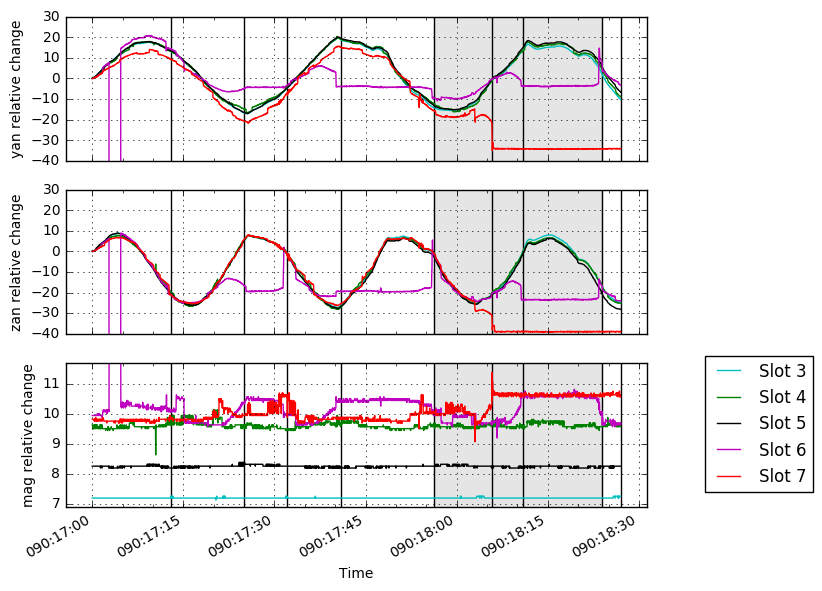

In [6]:
print("Gray vertical lines: times t1-t6")

plt.close(1)
plt.figure(figsize=(7.5, 7))

ylims = [(-40, 30), (-40, 30), (6.9, 11.7)]

for idx, coord in enumerate(['yan', 'zan', 'mag']):
    plt.subplot(3, 1, idx + 1)
    for slot, color in zip(np.arange(3, 8), 'cgkmr'):
            msid = dat['aoac{}{}'.format(coord, slot)]
            if idx in [0, 1]:
                plot_cxctime(msid.times, msid.vals - msid.vals[0], color,
                             label='Slot {}'.format(slot))
            else:
                plot_cxctime(msid.times, msid.vals, color,
                             label='Slot {}'.format(slot))
    plt.ylim(ylims[idx])
    plt.ylabel("{} relative change".format(coord))
    plt.grid()
    plt.vlines(DateTime(times).plotdate, -40, 30, 'k')
    plt.margins(0.05)

    
plt.xlabel('Time')
plt.legend(loc=(1.1, 0.1))
axes = plt.gcf().axes
for ax in axes:
    ax.axvspan(DateTime(t5).plotdate, DateTime(t8).plotdate,
               color='gray', alpha=0.2)

plt.show()

### ACA image snapshots between 17:56:05 and 18:23:34 ###

<img style="float: left" src='snaps/17_56_05.png' width='670'> Just after star image<br>
is recovered in slot 6<br>
<img style="float: left" src='snaps/18_02_31.png' width='670'><br><br><br><br><br><br>
<img style="float: left" src='snaps/18_03_02.png' width='670'><br>Hot pixel takes over<br>
slot 7, another hot pixel<br> starts disturbing slot 6<br>
<img style="float: left" src='snaps/18_03_03.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_03_08.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_05_59.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_10_38.png' width='670'><br><br><br>Hot pixels tracked<br>
in slots 6 and 7<br><br>
<img style="float: left" src='snaps/18_23_34.png' width='670'><br>Star image recovered<br>
in slot 6<br>

__Spoiler stars in slots 6 and 7?__

In [7]:
q_18983 = Quat([0.49947489, -0.33350427, -0.75701845, 0.25733791])

# Catalog star in slot 6:
yag = -164
zag = -1661
radius = 120 / 3600.
ra, dec = quatutil.yagzag2radec(yag / 3600., zag / 3600., q_18983)
cat = agasc.agasc.get_agasc_cone(ra, dec, radius=radius, date='2017:090')
print(cat['AGASC_ID', 'RA', 'DEC', 'MAG_ACA'])
print()

# Catalog star in slot 7:
# print(dat['aoacyan7'].vals[0]) # confirm that this is the GUI not ACQ star
yag = 1382
zag = -1612
radius = 80 / 3600.
ra, dec = quatutil.yagzag2radec(yag / 3600., zag / 3600., q_18983)
cat = agasc.agasc.get_agasc_cone(ra, dec, radius=radius, date='2017:090')
print(cat['AGASC_ID', 'RA', 'DEC', 'MAG_ACA'])

 AGASC_ID      RA          DEC      MAG_ACA
--------- ------------ ------------ -------
964036328    243.46819     -35.9956  12.146
964036728 243.49526469 -35.97335126 9.77248

 AGASC_ID      RA          DEC      MAG_ACA
--------- ------------ ------------ -------
963519712 243.65820296 -35.56467336 9.85853
963517312     243.6445    -35.55775  12.836
963520416 243.64080876 -35.55061824 10.8222


### Identification of the two warm pixels ###

In [9]:
dccimg = aca_dark.dark_cal.get_dark_cal_image('2017:092', select='nearest', aca_image=True)

d = events.dwells.filter(obsid=18983)[0]

warm_pixels = []

for slot in [6, 7]:
    slot_imgs = aca_l0.get_l0_images('2017:090:18:20:06', '2017:090:18:20:10', slot=slot)
    slot_data = slot_imgs[0]

    r, c = np.unravel_index(np.argmax(slot_data), dims=slot_data.shape)
    col = c + slot_data.col0
    row = r + slot_data.row0
    
    print('Slot {}'.format(slot))
    print()
    print('ACA image:')
    print('Coords of warm pixel (row, col) = ({}, {})'.format(row, col))
    print((slot_data * 5 / 1.7).astype(int))
    print()
 
    warm_pixels.append((row, col))
        
    section = dccimg[slot_data]
    print('Corresponding section of the 2017/092 ACA DCC image:')
    print((section).astype(int))
    print()


Slot 6

ACA image:
Coords of warm pixel (row, col) = (40, -332)
[[   0  250   26   76   97    0]
 [  26    2  308  247  211   17]
 [   2   35  161  214   14   14]
 [   0  238   14 1967   55  150]
 [  -5    0   11    0   14   17]
 [   0  117   14   97    5    0]]

Corresponding section of the 2017/092 ACA DCC image:
[[ 203  350   48  110  195   17]
 [ 170   25  444  391  152   32]
 [  19   36  192  255   37   32]
 [  27  265   30 2708  123  236]
 [  32   23   15   19   16   35]
 [  53  297   23  144   10  251]]

Slot 7

ACA image:
Coords of warm pixel (row, col) = (-267, -325)
[[   0    0   29    8    8    0]
 [   5   14   23   97  129    8]
 [  -2  402   20 2217  220   20]
 [  88   11  100   41   47    8]
 [  73  185   76   32   44    8]
 [   0  311   73   79   -2    0]]

Corresponding section of the 2017/092 ACA DCC image:
[[ 143   24   18   23   13   17]
 [  27   24    7  318  110   19]
 [  38  334   28 2062  271   32]
 [ 226   28  174   36  117   19]
 [ 151  234  116   30   61   32]

ACA dark current calibration taken on 2017/092 shows two pixels with at >2000 e-/sec with coordinates matching the coordinates of the hot pixels tracked in slots 6 and 7.

### Probability of hitting hot pixels with >2000 e-/sec in *N* image windows###

The two warm pixels in slots 6 and 7 were observed at approximately 2000 e-/sec. According to the dark current calibration taken on 2017/092, the ACA CCD has approximately __200__ pixels with value >= 2000 e-/sec.

<img style='float: left' src='cum_dist.gif'>

In [10]:
import math

def get_hot_pixel_hits(ccd_size, window_size, n_hp, n_image_windows):
    """
    Use simulations to compute probability of hitting
    m of n_hp hot pixes when n_image_windows are scheduled.
    """
    
    ccd = np.zeros(ccd_size * ccd_size)
    
    # coordinates of n_hp hot pixels
    hp_coords = np.random.randint(0, ccd_size, 2 * n_hp)
    hp_coords = hp_coords.reshape(n_hp, 2)
    
    # draw row0, col0 of N image windows
    # check if the windows overlap?
    row0col0 = np.random.randint(0, ccd_size, 2 * n_image_windows)
    row0col0 = row0col0.reshape(n_image_windows, 2)

    scheduled_pixels = []

    for row0, col0 in row0col0:
        for rr in range(window_size):
            for cc in range(window_size):
                scheduled_pixels.append((row0 + rr, col0 + cc))
                
    hits = 0
    for hp_row, hp_col in hp_coords:
        if (hp_row, hp_col) in scheduled_pixels:
            hits = hits + 1
            
    return hits


def prob_m_warm_pixels(m, ccd_size, window_size, n_hp, n_image_windows):
    """
    Calculate probability of hitting m of n_hp hot pixes when
    n_image_windows are scheduled (i.e. numer of trials is
    k = n_image_windows * 12 * 12).
    """
    
    n = ccd_size * ccd_size
    # account for dither
    k = n_image_windows * window_size * window_size
    
    a1 = np.prod(np.arange(k - m + 1, k + 1))
    a2 = np.prod(np.arange(n_hp - m + 1, n_hp + 1))
    a3 = np.prod(np.arange(n - n_hp + 1, n - n_hp + m + 1))
    
    a = []
    for i in range(n_hp - m):
        a.append((n - n_hp - k + m + 1. + i) / (n - n_hp + m + 1. + i))
        
    nom = a1 * a2 * np.prod(a)
    den = a3 * math.factorial(m)
    
    return nom / den

In [11]:
window_size = 11 # to account for dither
ccd_size = 1024
n_hp = 200

__Simulations__

In [12]:
n_image_windows = 5

probs = {}
distr = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0}
n_trials = 20000
for i in range(n_trials):
    hits = get_hot_pixel_hits(ccd_size, window_size, n_hp, n_image_windows)
    distr['{}'.format(hits)] = distr['{}'.format(hits)] + 1
    
print(distr)

for key in distr.keys():
    probs[key] = distr[key] / n_trials
    
print(probs)

{'3': 4, '5': 0, '1': 2104, '2': 109, '4': 0, '0': 17783}
{'3': 0.0002, '5': 0.0, '1': 0.1052, '2': 0.00545, '4': 0.0, '0': 0.88915}


In [13]:
n_image_windows = 8

probs = {}
distr = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0}
n_trials = 20000
for i in range(n_trials):
    hits = get_hot_pixel_hits(ccd_size, window_size, n_hp, n_image_windows)
    distr['{}'.format(hits)] = distr['{}'.format(hits)] + 1
    
print(distr)

for key in distr.keys():
    probs[key] = distr[key] / n_trials
    
print(probs)

{'3': 10, '5': 0, '1': 3007, '2': 290, '4': 0, '0': 16693}
{'3': 0.0005, '5': 0.0, '1': 0.15035, '2': 0.0145, '4': 0.0, '0': 0.83465}


__Math__

Probability of detecting $m$ warm pixels:


\begin{equation}
P(m) = \frac{{N_{WP} \choose m}{N - N_{WP} \choose k - m}}{{N \choose k}},
\end{equation}

where:
* $N$ = 1024 x 1014 is the total number of CCD pixels,
* $N_{\rm WP}$ is the number of warm pixels,
* $k$ is the number of drawn pixel samples, $k =$ n_image_windows x 11 x 11 (to account for dither).

For $N_{\rm WP}$ = 200 pixels with value >= 2000 e-/sec:

In [14]:
m = 1

n_image_windows = 5
prob = prob_m_warm_pixels(m, ccd_size, window_size, n_hp, n_image_windows)
print('Probability of detecting {} warm pixels in {} windows: {:.5f}'.format(m,
                                                                             n_image_windows,
                                                                             prob))
n_image_windows = 8
prob = prob_m_warm_pixels(m, ccd_size, window_size, n_hp, n_image_windows)
print('Probability of detecting {} warm pixels in {} windows: {:.5f}'.format(m,
                                                                             n_image_windows,
                                                                             prob))

Probability of detecting 1 warm pixels in 5 windows: 0.10289
Probability of detecting 1 warm pixels in 8 windows: 0.15366


In [15]:
m = 2

n_image_windows = 5
prob = prob_m_warm_pixels(m, ccd_size, window_size, n_hp, n_image_windows)
print('Probability of detecting {} warm pixels in {} windows: {:.5f}'.format(m,
                                                                             n_image_windows,
                                                                             prob))
n_image_windows = 8
prob = prob_m_warm_pixels(m, ccd_size, window_size, n_hp, n_image_windows)
print('Probability of detecting {} warm pixels in {} windows: {:.5f}'.format(m,
                                                                             n_image_windows,
                                                                             prob))

Probability of detecting 2 warm pixels in 5 windows: 0.00590
Probability of detecting 2 warm pixels in 8 windows: 0.01412


__Warm pixels time history__

In [16]:
times_hp = []
vals_hp = []

for slot, coords in zip([6, 7], warm_pixels):

    vv = []
    tt = []

    slot_imgs = aca_l0.get_l0_images(start, stop, slot=slot)
    slot_data = aca_l0.get_slot_data(start, stop, slot=slot)

    for idx, slot_img in enumerate(slot_imgs):
  
        hp_row = coords[0] - slot_img.row0
        hp_col = coords[1] - slot_img.col0

        if hp_row in range(6) and hp_col in range(6):
            r, c = np.unravel_index(np.argmax(slot_img), dims=slot_img.shape)
            col = c + slot_img.col0
            row = r + slot_img.row0
            val = (slot_img[hp_row][hp_col] * 5 / 1.7).astype(int)
        else:
            val = 0

        vv.append(val)
        tt.append(slot_data[idx]['TIME'])
        

    times_hp.append(tt)
    vals_hp.append(vv)

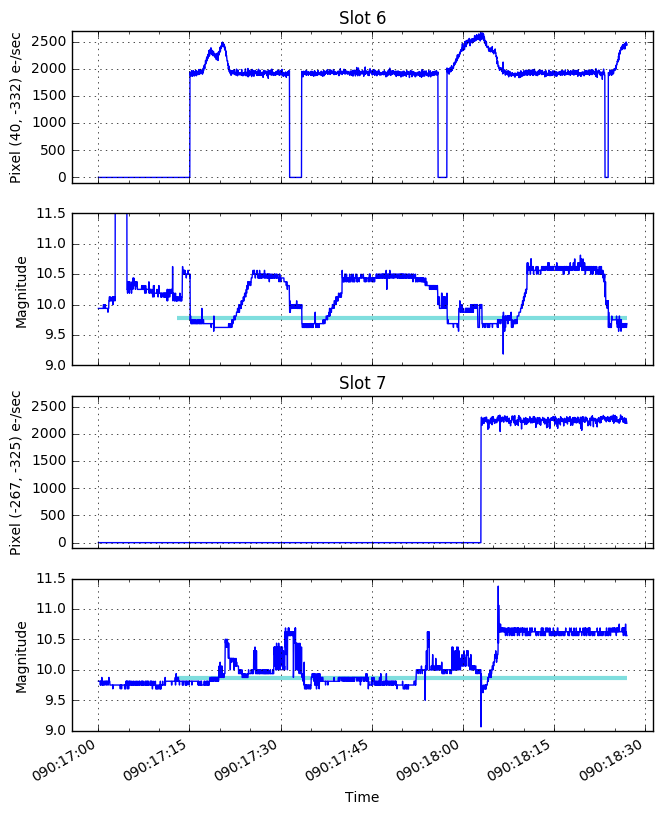

In [27]:
plt.figure(figsize=(7.5, 10))

mag_aca = [9.772, 9.859]

for ii, slot in enumerate([6, 7]):

    plt.subplot(4, 1, 2 * ii + 1)

    plot_cxctime(times_hp[ii], vals_hp[ii])
    plt.grid()
    plt.ylim(-100, 2700)
    plt.margins(0.05)
    plt.ylabel('Pixel {} e-/sec'.format(warm_pixels[ii]))
    plt.title('Slot {}'.format(slot))

    plt.subplot(4, 1, 2 * ii + 2)

    plot_cxctime(dat['aoacmag{}'.format(slot)].times,
                 dat['aoacmag{}'.format(slot)].vals)
    plt.hlines(mag_aca[ii],
               DateTime(times[0]).plotdate, DateTime(times[-1]).plotdate,
               color='c', alpha=0.5, lw=3)
    plt.ylim(9, 11.5)
    plt.grid()
    plt.margins(0.05)
    plt.ylabel('Magnitude')
    plt.xlabel('Time')

plt.show()

### Change in Ground and OBC atitude estimates ###

In [28]:
#OBSID: 18983  IGR J16120-3543        ACIS-I SIM Z offset:0     (0.00mm) Grating: NONE 
#RA, Dec, Roll (deg):   242.979061   -35.773101    69.916905
#Dither: ON  Y_amp=16.0  Z_amp=16.0  Y_period=2000.0  Z_period=1414.8
#
#MP_TARGQUAT at 2017:090:16:35:48.735 (VCDU count = 14952866)
#  Q1,Q2,Q3,Q4: 0.49947489  -0.33350427  -0.75701845  0.25733791

Q1, Q2, Q3, Q4 = [0.49947489, -0.33350427, -0.75701845, 0.25733791]
q_planned = Quat([Q1, Q2, Q3, Q4])

In [29]:
#import Ska.arc5gl
#arc5gl = Ska.arc5gl.Arc5gl()
#arc5gl.sendline('obsid=18983')
#arc5gl.sendline('version=last')
#arc5gl.sendline('get asp1{obcsol}')
#del arc5gl

In [30]:
obc_file = 'pcadf607365442N001_osol1.fits.gz'
obc_sol = Table.read(obc_file)[1336:]

In [31]:
asol_file = 'pcadf607366811N001_asol1.fits.gz'
grnd_sol = Table.read(asol_file)

In [32]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(atts['time'], drs, '-b', label='Roll')
    plot_cxctime(atts['time'], dps, '-g', label='Pitch')
    plot_cxctime(atts['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.xlabel('Time')
    #plt.legend(loc='best');

In [33]:
dat_gb = fetch.MSIDset(['aogbias*'], start=grnd_sol['time'][0], stop=grnd_sol['time'][-1])

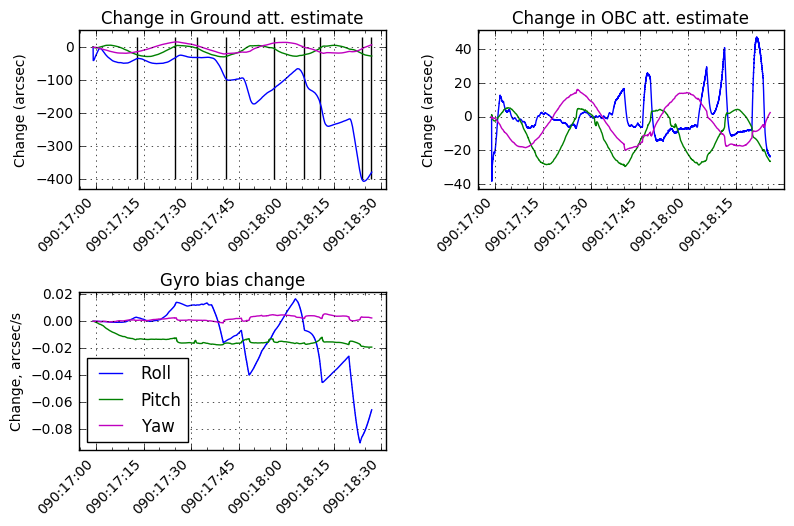

In [34]:
plt.figure(figsize=(7.5, 6))

plt.subplot(2, 2, 1)

label = 'Change in Ground att. estimate'
plot_att_changes(refs=grnd_sol[:1], atts=grnd_sol, label=label)
plt.vlines(DateTime(times).plotdate, -400, 30, 'k')

plt.subplot(2, 2, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=obc_sol[:1], atts=obc_sol, label=label)

# Gyro bias
plt.subplot(2, 2, 3)

labels = ['Roll', 'Pitch', 'Yaw']
for i, color in zip(range(3), 'bgm'):
    msid = dat_gb['aogbias{}'.format(i + 1)]
    plot_cxctime(msid.times,
                 ((msid.vals - msid.vals[0]) * u.radian / u.s).to('arcsec/s'),
                 color=color,
                 label=labels[i])
plt.grid()
plt.margins(0.05)
plt.ylabel('Change, arcsec/s')
plt.title('Gyro bias change')
plt.legend(loc='best')

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3, hspace=0.65)

plt.show()

## ObsID 19924 ##

### Change in OBC estimated attitude relative to the final BSH attitude###

In [35]:
start = '2017:090:18:54:00'
stop = '2017:090:19:15:00'
dat_seq = fetch.MSID('aoacaseq', start, stop)

In [36]:
vals = []
seqs = ['BRIT', 'AQXN', 'GUID', 'KALM']
for i, seq in enumerate(seqs):
    vals.append((dat_seq.vals == seq) * (i + 1))

In [37]:
obc_file = 'pcadf607372002N001_osol1.fits.gz'
obc_sol = Table.read(obc_file)[1666:2894]

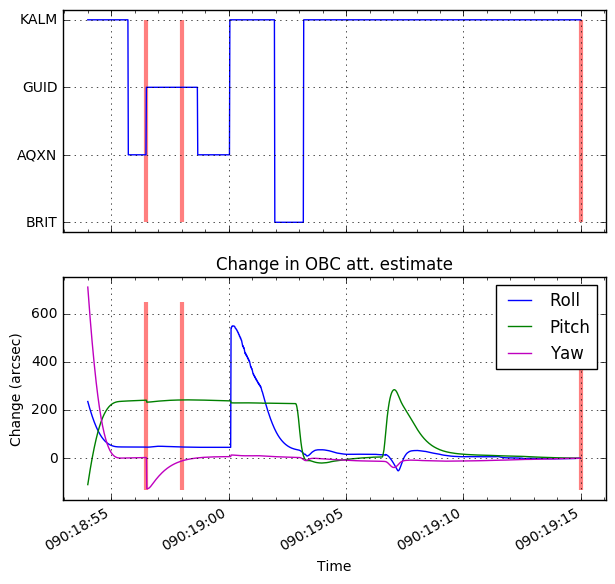

In [38]:
times = ['2017:090:19:15:00', '2017:090:18:58:00', '2017:090:18:56:28']

plt.figure(figsize=(7, 7))

plt.subplot(2, 1, 1)

plot_cxctime(dat_seq.times, np.sum(vals, axis=0))
plt.yticks([1, 2, 3, 4], seqs)
plt.grid()
plt.vlines(DateTime(times).plotdate, 1, 4, 'red', alpha=0.5, lw=3)
plt.margins(0.05)

plt.subplot(2, 1, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=obc_sol[-1:], atts=obc_sol, label=label)
plt.legend(loc='best')
plt.vlines(DateTime(times).plotdate, -130, 650, 'red', alpha=0.5, lw=3)
plt.margins(0.05)

plt.show()

In [39]:
#dump2occ.py 2017_090_1147_090_2026_Dump_EM_54052N001.sto | splat.pl -vcdu 14952866

<img style="float: left" src='snaps/18_56_19.png' width='670'> 1st ACXN, <br>
Slot 6, warm pixel<br><br>
<img style="float: left" src='snaps/18_56_31.png' width='670'> <br><br>
Slot 2, star<br><br>
<img style="float: left" src='snaps/18_57_00.png' width='670'> <br><br>GUID <br><br>
<img style="float: left" src='snaps/18_57_56.png' width='670'> <br><br><br>
Slot 2, star corrupted<br>
due to a hot pixel?<br>
<img style="float: left" src='snaps/18_58_17.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_26.png' width='670'><br><br> 2nd AQXN,<br>
Slots 0-2 FIDs<br>Slots 6-7 hot pixels<br>
<img style="float: left" src='snaps/18_58_30.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_42.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_51.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_54.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/18_58_57.png' width='670'><br><br><br><br>
<img style="float: left" src='snaps/19_00_02.png' width='670'><br><br><br>KALM<br>
Slot 2, same star<br>
as during the 1st AQXN<br>
<img style="float: left" src='snaps/19_02_10.png' width='670'><br><br>KALM -> BRIT<br>
<img style="float: left" src='snaps/19_03_11.png' width='670'><br><br><br>BRIT -> KALM<br>
Slot 6, slightly affected<br> by a hot pixel<br>
<img style="float: left" src='snaps/19_07_18.png' width='670'>
<img style="float: left" src='snaps/19_07_45.png' width='670'>
<img style="float: left" src='snaps/19_07_52.png' width='670'>
<img style="float: left" src='snaps/19_08_43.png' width='670'>

In [40]:
time_guide = '2017:090:19:00:02'
time_acqn = '2017:090:18:57:00'

dat_bsh = fetch.MSIDset(['aoacyan*', 'aoaczan*', 'aoacmag*'], start, stop)

In [41]:
#Compare mags of the star acquired in slot 2 and then in slot 6:
tt = ['2017:090:18:56:31', '2017:090:18:57:56', '2017:090:19:00:02', '2017:090:19:03:11']
slots = [2, 2, 2, 6]
seqs = ['AQXN', 'GUID', 'KALM', 'BRIT']
for time, slot, seq in zip(tt, slots, seqs):
    idx = (np.abs(dat_bsh['aoacyan0'].times - DateTime(time).secs)).argmin()
    mag = dat_bsh['aoacmag{}'.format(slot)].vals[idx]
    print('{} Slot {}:  mag = {}'.format(seq, slot, mag))

AQXN Slot 2:  mag = 9.4375
GUID Slot 2:  mag = 9.4375
KALM Slot 2:  mag = 9.5
BRIT Slot 6:  mag = 9.4375


## Star AGASC_ID = 1200884696 ##

In [43]:
t = Table(agasc.agasc.get_star(1200884696))
t['RA'].format = '%.3f'
t['DEC'].format = '%.3f'
t['MAG_ACA'].format = '%.3f'
print(t['AGASC_ID', 'RA', 'DEC', 'MAG_ACA'])

 AGASC_ID    RA     DEC   MAG_ACA
---------- ------ ------- -------
1200884696 79.224 -68.353   9.697


In [44]:
dat_att = fetch.MSIDset(['aoattqt*'], start, stop)

In [45]:
idx = (np.abs(dat_bsh['aoacyan0'].times - DateTime('2017:090:19:15:00').secs)).argmin()

# BSH quaternion
q_true = []
for i in range(4):
    q_true.append(dat_att['aoattqt{}'.format(i + 1)].vals[idx])   
q_true = Quat(q_true)

# transformation to the time of GUID

dq_guid = Quat([0, -219 / 3600., 800 / 3600.])
dq_aqxn1 = Quat([-116 / 3600., -219 / 3600., 800 / 3600.])

q_guid = q_true * dq_guid
q_aqxn1 = q_true * dq_aqxn1

In [46]:
ra = t['RA'][0]
dec = t['DEC'][0]

tstar = Table(names=('slot', 'yag_o', 'yag_p', 'dyag', 'zag_o', 'zag_p', 'dzag'))

quats = [q_true, q_guid, q_aqxn1]
slots = [6, 2, 2]
times = ['2017:090:19:15:00', '2017:090:18:58:00', '2017:090:18:56:28']

for quat, slot, time in zip(quats, slots, times):
    msidy = 'aoacyan{}'.format(slot)
    msidz = 'aoaczan{}'.format(slot)
    idx = (np.abs(dat_bsh['aoacyan0'].times - DateTime(time).secs)).argmin()
    yag_o, zag_o = (dat_bsh[msidy].vals[idx], dat_bsh[msidz].vals[idx])
    yag_p, zag_p = quatutil.radec2yagzag(ra, dec, quat)
    dyag = yag_o - yag_p * 3600
    dzag = zag_o - zag_p * 3600
    tstar.add_row([slot,
                   yag_o, yag_p * 3600, dyag,
                   zag_o, zag_p * 3600, dzag])

tstar['slot'].format = '%2i'
cols = tstar.colnames
cols.remove('slot')
for col in cols:
    tstar[col].format = '%.3f'

tstar['seq'] = ['BRIT', 'GUID', 'AQXN1']
    
print(tstar)

slot   yag_o     yag_p    dyag   zag_o    zag_p    dzag   seq 
---- --------- --------- ------ -------- -------- ------ -----
   6 -2182.125 -2181.126 -0.999 1678.675 1673.612  5.063  BRIT
   2 -2172.000 -2173.790  1.790 1915.250 1901.057 14.193  GUID
   2 -2057.250 -2057.789  0.539 1906.100 1900.598  5.502 AQXN1
